<a href="https://colab.research.google.com/github/poudyaldiksha/Data-Science-project/blob/main/Lesson_39_b2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 39: Simple Linear Regression - Model Evaluation



Today, We will learn how to build a linear regression model using the `sklearn` module to avoid using the math behind it.

and also we will learn to evaluate the accuracy of a simple linear regression model by calculating the coefficient of determination, MSE, RMSE and MAE values.





---

### Recap

In [ ]:
# Run the code cell.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset.
csv_file = '/content/AirQualityUCI.csv'
df = pd.read_csv(csv_file, sep=';')


# Dropping the 'Unnamed: 15' & 'Unnamed: 16' columns.
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], axis=1)

# Dropping the null values.
df = df.dropna()

# Creating a Pandas series containing 'datetime' objects.
dt_series = pd.Series(data = [item.split("/")[2] + "-" + item.split("/")[1] + "-" + item.split("/")[0] for item in df['Date']], index=df.index) + ' ' + pd.Series(data=[str(item).replace(".", ":") for item in df['Time']], index=df.index)
dt_series = pd.to_datetime(dt_series)

# Remove the Date & Time columns from the DataFrame and insert the 'dt_series' in it.
df = df.drop(columns=['Date', 'Time'], axis=1)
df.insert(loc=0, column='DateTime', value=dt_series)

# Get the Pandas series containing the year values as integers.
year_series = dt_series.dt.year

# Get the Pandas series containing the month values as integers.
month_series = dt_series.dt.month

# Get the Pandas series containing the day values as integers.
day_series = dt_series.dt.day

# Get the Pandas series containing the days of a week, i.e., Monday, Tuesday, Wednesday etc.
day_name_series = dt_series.dt.day_name()

# Add the 'Year', 'Month', 'Day' and 'Day Name' columns to the DataFrame.
df['Year'] = year_series
df['Month'] = month_series
df['Day'] = day_series
df['Day Name'] = day_name_series

# Sort the DataFrame by the 'DateTime' values in the ascending order. Also, display the first 10 rows of the DataFrame.
df = df.sort_values(by='DateTime')

# Create a function to replace the commas with periods in a Pandas series.
def comma_to_period(series):
    new_series = pd.Series(data=[float(str(item).replace(',', '.')) for item in series], index=df.index)
    return new_series

# Apply the 'comma_to_period()' function on the ''CO(GT)', 'C6H6(GT)', 'T', 'RH' and 'AH' columns.
cols_to_correct = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'] # Create a list of column names.
for col in cols_to_correct: # Iterate through each column
    df[col] = comma_to_period(df[col]) # Replace the original column with the new series.

# Remove all the columns from the 'df' DataFrame containing more than 10% garbage value.
df = df.drop(columns=['NMHC(GT)', 'CO(GT)', 'NOx(GT)', 'NO2(GT)'], axis=1)

# Create a new DataFrame containing records for the years 2004 and 2005.
aq_2004_df = df[df['Year'] == 2004]
aq_2005_df = df[df['Year'] == 2005]

# Replace the -200 value with the median values for each column having indices between 1 and -4 (excluding -4) for the 2004 year DataFrame.
for col in aq_2004_df.columns[1:-4]:
  median = aq_2004_df.loc[aq_2004_df[col] != -200, col].median()
  aq_2004_df[col] = aq_2004_df[col].replace(to_replace=-200, value=median)

# Repeat the same exercise for the 2005 year DataFrame.
for col in aq_2005_df.columns[1:-4]:
  median = aq_2005_df.loc[aq_2005_df[col] != -200, col].median()
  aq_2005_df[col] = aq_2005_df[col].replace(to_replace=-200, value=median)

# Group the DataFrames about the 'Month' column.
group_2004_month = aq_2004_df.groupby(by='Month')
group_2005_month = aq_2005_df.groupby(by='Month')

# Concatenate the two DataFrames for 2004 and 2005 to obtain one DataFrame.
df = pd.concat([aq_2004_df, aq_2005_df])

# Information of the DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DateTime       9357 non-null   datetime64[ns]
 1   PT08.S1(CO)    9357 non-null   float64       
 2   C6H6(GT)       9357 non-null   float64       
 3   PT08.S2(NMHC)  9357 non-null   float64       
 4   PT08.S3(NOx)   9357 non-null   float64       
 5   PT08.S4(NO2)   9357 non-null   float64       
 6   PT08.S5(O3)    9357 non-null   float64       
 7   T              9357 non-null   float64       
 8   RH             9357 non-null   float64       
 9   AH             9357 non-null   float64       
 10  Year           9357 non-null   int32         
 11  Month          9357 non-null   int32         
 12  Day            9357 non-null   int32         
 13  Day Name       9357 non-null   object        
dtypes: datetime64[ns](1), float64(9), int32(3), object(1)
memory usage: 986.9+ KB

The description for all the columns containing data for air pollutants, temperature, relative humidity and absolute humidity is provided below.


|Columns|Description|
|-|-|
|PT08.S1(CO)|PT08.S1 (tin oxide) hourly averaged sensor response (nominally $\text{CO}$ targeted)|
|C6H6(GT)|True hourly averaged Benzene concentration in $\frac{\mu g}{m^3}$|
|PT08.S2(NMHC)|PT08.S2 (titania) hourly averaged sensor response (nominally $\text{NMHC}$ targeted)|
|PT08.S3(NOx)|PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_x$ targeted)|
|PT08.S4(NO2)|PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally $\text{NO}_2$ targeted)|
|PT08.S5(O3) |PT08.S5 (indium oxide) hourly averaged sensor response (nominally $\text{O}_3$ targeted)|
|T|Temperature in Â°C|
|RH|Relative Humidity (%)|
|AH|AH Absolute Humidity|

In [ ]:
# Heatmap to pinpoint the columns in the 'df' DataFrame exhibiting high correlation.
corr_df = df.iloc[:, 1:-4].corr()
plt.figure(figsize = (10, 6), dpi = 96)
sns.heatmap(data = corr_df, annot = True) # 'annot=True' fills the R values in the heatmap cells.
plt.show()

---

#### Train-Test Split

There is no fixed rule to what should be the size of train and test sets. However, the training set should always have more instances than the test set. So in general, you can have the 70% of instances in the train set and the remaining 30% in the test set. In general, you may split a DataFrame in such a way that a train set contains 67% to 80% of the instances.


In [ ]:
# Splitting the DataFrame into the train and test sets.
from sklearn.model_selection import train_test_split

X = df['T'] # Pandas DataFrame containing only feature variables
y = df['RH'] # Pandas Series containing the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

If you don't specify the `random_state` parameter in your code, then every time you run (or execute) your code, a new random value is generated and the train and test datasets will have different values each time.

However, if a fixed value is assigned like `random_state = 42` then regardless of the number of times you execute your code, the result will be the same i.e., same values in train and test datasets.


In [ ]:
type(X_train)

pandas.core.series.Series

---

#### Model Training

Let the equation of the best fit line be $$y = mx + c$$

Here,
- $y$ represents the relative humidity values on the $y$-axis
- $x$ represents the temperatures values on the $x$-axis
- $m$ is the slope of the line
- $c$ is the intercept made by the line on the $y$-axis


$$\Rightarrow m = \frac{\sum(x_i - \bar{x})(y_i - \bar{y})}{\sum (x_i - \bar{x})^2}$$


where
- $x_i$ is each instance of the feature variable. In this case, $x_i$ represents each temperature value.

- $\bar{x}$ is the average (or mean) value of the feature variable. In this case, $\bar{x}$ is the average temperature value.

- $y_i$ is each instance of the target variable. In this case, $y_i$ represents each relative humidity value.

- $\bar{y}$ is the average (or mean) value of the target variable. In this case, $\bar{y}$ is the average relative humidity value.

- $n$ is the total number of instances.


The intercept i.e. $c$ is given by
$$c = \bar{y} - m \bar{x}$$


**Note:** The differences between a value and the mean value is also referred to as **residuals** or **errors**.


In [ ]:
# Create the 'errors_product()' and 'squared_errors()' function.
def errors_product():
  prod = (X_train - X_train.mean()) * (y_train - y_train.mean())
  return prod

def squared_errors():
  sq_errors = (X_train - X_train.mean()) ** 2
  return sq_errors

# Calculate the slope and intercept values for the best fit line.
slope = errors_product().sum()/ squared_errors().sum()
intercept = y_train.mean() - slope * X_train.mean()

print(f"Slope: {slope} \nIntercept: {intercept}")

Slope: -1.112053910794772 
Intercept: 69.69110324644876


As you can see, we have obtained the slope and intercept values for the best fit line.

Hence, the required equation of the best fit line is
$$y = -1.1120x + 69.6911$$

or
$$\text{relative humidity} =  -1.1120 \times \text{temperature} + 69.6911$$

which is also the regression line.

Let's plot this line along with the scatter plot to see how well it fits the points.

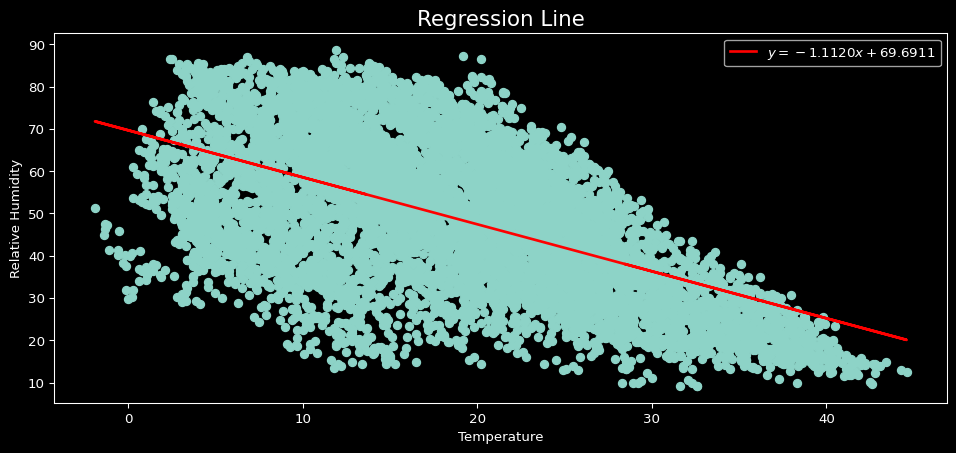

In [ ]:
# Plot the regression line in the scatter plot between relative humidity and temperature values.
plt.style.use('dark_background')
plt.figure(figsize = (12, 5), dpi = 96)
plt.title("Regression Line", fontsize = 16)
plt.scatter(df['T'], df['RH'])
plt.plot(df['T'], slope * df['T'] + intercept, color = 'r', linewidth = 2, label = '$y = −1.1120x + 69.6911$')
plt.xlabel("Temperature")
plt.ylabel("Relative Humidity")
plt.legend()
plt.show()

<Axes: xlabel='T', ylabel='RH'>

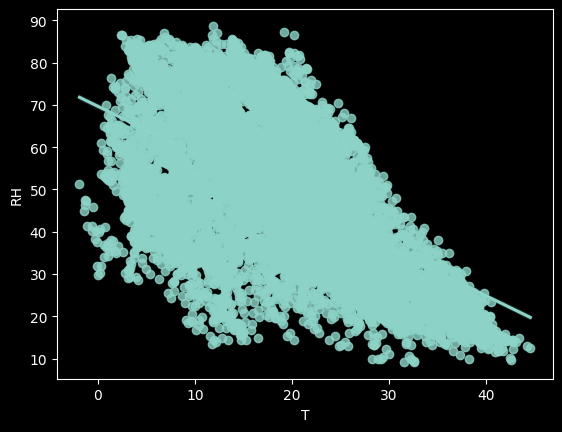

In [ ]:
sns.regplot(x = df['T'],y = df["RH"])

From the naked eye observation, it seems the regression line that we obtained fits pretty well all the points in the scatter plot. But let's evaluate our model using Coefficient of Determination (R-squared).

---

#### Activity 1: Simple Linear Regression Using `sklearn` Module

If the mathematical details of linear regression seem overwhelming, you can simplify the process by using the sklearn (Scikit-Learn) Python library, which offers a convenient way to implement linear regression models. `Scikit-Learn's linear_model` module allows you to fit a linear regression model with minimal effort, abstracting away the complex math behind the scenes.

Before using `Scikit-Learn's LinearRegression class`, it's important to prepare your data correctly.

Specifically, the input feature set and the target variable must be in the form of **two-dimensional arrays**. If your data is currently in one-dimensional arrays (e.g., a single column from a Pandas DataFrame), you'll need to reshape them into two dimensions.

This reshaping is crucial because Scikit-Learn expects the input features to be a 2D array, where rows represent individual data points and columns represent different features.

In [ ]:
#  Print the dimensions of the feature and target variable arrays/series.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(6269,)
(6269,)
(3088,)
(3088,)


In [ ]:
X_train_ex = np.array(X_train)
type(X_train_ex)
X_train_ex.reshape(-1,1)


array([[24.7],
       [25. ],
       [22.1],
       ...,
       [22.6],
       [19.2],
       [13.3]])

To convert a one-dimensional array into a two-dimensional array, use the `reshape(-1, 1)` function of `numpy` module.

The `reshape(-1, 1)` function does not work on a Pandas series. It works on a NumPy array. Hence, you need to create a NumPy array from a Pandas series. So, either you can convert a Pandas series into a NumPy array using the `array()` function of the `numpy` module or you can use the `values` attribute of the Pandas series object.

In [ ]:
type(X_train.values)

numpy.ndarray

In [ ]:
np.array([1,2,3,4,5,6]).reshape(-1,3)

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
# Create two-dimensional NumPy arrays from one-dimensional Pandas series for the feature and target variables.
print(type(X_train.values))

X_train_reshaped = X_train.values.reshape(-1, 1)
y_train_reshaped = y_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

print(X_train_reshaped.shape)
print(y_train_reshaped.shape)
print(X_test_reshaped.shape)
print(y_test_reshaped.shape)

Now, let's deploy a linear regression model using the `sklearn` module. For this, follow the steps given below:

1. Import the `LinearRegression` class from the `sklearn.linear_model` module.
2. Create an object of the `LinearRegression` class.
3. Call the `fit()` function on the `LinearRegression` object with the input parameters as `X_train_reshaped` and `y_train_reshaped`.

The `fit()` function of the `LinearRegression` class will calculate the slope and intercept of the best fit line which you can get by calling the `coef_` and `intercept_` attributes respectively on the `LinearRegression` object.

**Syntax:**
> For slope: `object_name.coef_`

> For intercept: `object_name.intercept_`

In [ ]:
help(LinearRegression)

In [ ]:
# Deploy linear regression model using the 'sklearn.linear_model' module.

# 1. Import the 'LinearRegression' class from the 'sklearn.linear_model'.
from sklearn.linear_model import LinearRegression

# 2. Create an object of the 'LinearRegression' class.
lin_reg = LinearRegression()

# 3. Call the 'fit()' function
lin_reg.fit(X_train_reshaped, y_train_reshaped)

# 4. Print the slope and intercept values.
print(lin_reg.coef_)
print(lin_reg.intercept_)

In [ ]:

X = df[['T']] # Pandas DataFrame containing only feature variables
y = df['RH'] # Pandas Series containing the target variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Get the slope (m) and intercept (b)
m = model.coef_[0]
b = model.intercept_

print(f"Slope (m): {m}")
print(f"Intercept (b): {b}")

# Predict using the model
predictions = model.predict(X)

As you can see the slope and intercept values are the same as we got earlier without using the `sklearn` module to build a linear regression model.




#### Activity 2: The Coefficient of Determination (R-Squared)

The R-squared ($R^2$) tells us how much of the variance in one variable explains the variance in another variable. It is usually reported in terms of percentage.

Let's compute the coefficient of determination value which is one of the parameters that explains how much variation in one variable can be explained by the other variable through the linear regression model.

$$R^2 = 1 - \frac{\text{SSE}}{\text{SST}}$$

where

$$\text{SSE} = \sum(y - y_{\text{pred}})^2$$

and

$$\text{SST} = \sum(y - \bar{y})^2$$

**SSE** stands for the sum of squared errors i.e. errors between the actual and the predicted values. Consider the image shown below. Let there be 6 points on the scatter plot between the $x$ and $y$ values.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse1.png' width = 700></center>

Let there be a straight line which fits them the best as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse2.png' width = 700></center>

The points marked with the blue colour on the straight line are the corresponding predicted values to the red-coloured points. Let the arrows denote the distances between the blue and the red coloured points as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse3.png' width = 700></center>

The sum of these distances is the **squared sum of errors (SSE)**. These distances would have been lower if the red-coloured points were more close to the regression line as shown in the image below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse4.png' width = 700></center>

Hence, the SSE value would have been lower. The distance between the actual values and the predicted values are given by
$$|y_i - \hat{y_i}|$$
where
- $y_i$ is the $y$-coordinate of the actual value and
- $\hat{y_i}$ is the $y$-coordinate of the corresponding predicted value

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sse5.png' width = 700></center>

Lower the **SSE** value, higher the $R^2$ value. Higher the $R^2$ value, better is accuracy.

**SST** stands for the sum of squared **total** i.e. the errors between the actual values and their mean. Consider the image shown below.

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sst1.png' width = 700></center>

The mean of the actual target variable values i.e. $\bar{y}$ tries to fit all the points. The arrows represent the distances between the points and their mean values.

The sum of these distances is the **squared sum of total (SST)**. They are given by
$$|y_i - \bar{y}|$$
where
- $y_i$ is the $y$-coordinate of the actual value and
- $\bar{y}$ is their mean value

<center><img src = 'https://student-datasets-bucket.s3.ap-south-1.amazonaws.com/images/sst2.png' width = 700></center>

Also, it is the maximum possible error because the mean line is the worst fit line unless the points follow uniform distribution.

**Note:**

1. The terms **error, residual, difference** mean the same thing.
2. It goes without saying that the $R^2$ value will be between 0 and 1.


Let's define a function to calculate the $R^2$ value which will take 2 input parameters; feature dataset `X` and target series `y`. Let's name this function `r_squared()`. It should return the coefficient of determination value`. The following operations are to be performed inside the function:

1. Calculate the predicted values for the target variable using the $y = mx + c$ formula and store it in the `y_pred` variable.

2. Calculate the squared errors between the actual `y` values and the predicted `y` values i.e `y_pred`. Store them in the `sq_error` variable.

3. Calculate the squared total between the actual `y` values and the mean of the `y` values. Store them in the `sq_total` variable.

4. Calculate the sum of both the `sq_error` and `sq_total` series and then calculate the $R^2$ value using its formula.


Then calculate the $R^2$ value for the training set by using the `r_squared()` function.

In [ ]:
#  Calculate the r-squared value for the training set.
def r_squared(X, y):
    y_pred = slope * X + intercept
    sq_error = (y - y_pred) ** 2
    sq_total = (y - y.mean()) ** 2
    sse = sq_error.sum() # Sum of squared errors
    sst = sq_total.sum() # Sum of squared total
    r_squared = 1 - (sse / sst)
    return r_squared

r_squared(X_train, y_train)

The $R^2$ value is 32.46% approximately which denotes that 32.46% of the variance between the relative humidity and temperature is explained by the linear regression but the remaining 67.54% of the variance is still there.

Ideally, the $R^2$ value should be as close to 1 as possible for a best fit regression line.

**Note:** The $R^2$ value is a square of the correlation coefficient.


Let's calculate the square of the correlation coefficient to validate the above statement with the help of any one value by applying `np.corrcoef()` function on `X_train` and `y_train`.

In [ ]:
np.corrcoef(X_train, y_train)[0][1]

In [ ]:
# Calculate R-squared value by squaring the correlation coefficient value.
np.corrcoef(X_train, y_train)[0][1] ** 2

As it can be observed both the values are the same. Let's calculate the $R^2$ value for the test set as well.

In [ ]:
# Calculate R-squared value for the test set.
r_squared(X_test, y_test)

---

#### Activity 3: MSE, RMSE, MAE

Mean Squared Errors (MSE) is the mean of squares of the difference between the actual and the predicted values i.e.

$$\text{MSE} = \frac{1}{n} \sum(y_\text{actual} - y_\text{predicted})^2$$

where
- $y_\text{actual}$ is the set of actual values of the target variable

- $y_\text{predicted}$ is the set of predicted values of the target variable obtained by deploying some kind of prediction model

- $n$ is the total number of values

Root Mean Squared Errors (RMSE) is the square root of the mean squared errors (MSE) i.e.

$$\text{RMSE} = \sqrt{\frac{1}{n} \sum(y_\text{actual} - y_\text{predicted})^2}$$

$$\Rightarrow \text{RMSE} = \sqrt{\text{MSE}}$$

Mean Absolute Errors (MAE) is the mean of absolute values of the differences between the actual and the predicted values i.e.

$$\text{MAE} = \frac{1}{n} \sum \left|y_\text{actual}- y_\text{predicted} \right|$$

Let's create `mean_sq_error()`,`root_mean_sq_error()` and `mean_abs_error` functions to calculate the MSE, RMSE and MAE values using the above formulae respectively.

In [ ]:
#  Create functions to calculate the MSE, RMSE and MAE values.
def mean_sq_error(X, y_actual):
    y_pred = slope * X + intercept
    sq_error = (y_actual - y_pred) ** 2
    mse = sq_error.sum() / len(y_actual)
    return mse

def root_mean_sq_error(X, y_actual):
    y_pred = slope * X + intercept
    sq_error = (y_actual - y_pred) ** 2
    rmse = np.sqrt(sq_error.sum() / len(y_actual))
    return rmse

def mean_abs_error(X, y_actual):
    y_pred = slope * X + intercept
    abs_error = np.abs(y_actual - y_pred)
    mae = np.sum(abs_error) / len(y_actual)
    return mae

Let's call the functions created above to calculate the MSE, RMSE and MAE values for the train and test sets.

Also, round up the result (or output) upto 3 decimal places.

In [ ]:
# Calculate the MSE, RMSE and MAE values on the train and test sets.
print(f"Train Set\n{'-' * 50}")
print(f"Mean Squared Error (MSE): {mean_sq_error(X_train, y_train):.3f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_sq_error(X_train, y_train):.3f}")
print(f"Mean Absolute Error (MAE) {mean_abs_error(X_train, y_train):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"Mean Squared Error (MSE): {mean_sq_error(X_test, y_test):.3f}")
print(f"Root Mean Squared Error (RMSE): {root_mean_sq_error(X_test, y_test):.3f}")
print(f"Mean Absolute Error (MAE) {mean_abs_error(X_test, y_test):.3f}")


The closer the MSE, RMSE and MAE values are to zero, the better is accuracy of a regression-based prediction model. However, in the case of fractional values (or values between 0 and 1), MAE is a better metric to evaluate the accuracy of a regression-based prediction model. This is because squaring fractional values will take them even more close to zero, e.g. $0.1^2 = 0.01$

---

#### Activity 4:  Evaluate the linear regression model using`sklearn` Module





Now let's predict the values for both training and test sets and evaluate the model with the help of R-squared, MSE, RMSE and MAE parameters. For this, again you can use the `sklearn` module.

1. Import `r2_score, mean_squared_error` and `mean_absolute_error` functions from the `sklearn.metrics` module.

2. Calculate the predicted values (here `y_train_pred` and `y_test_pred`) for the feature variables (here `X_train_reshaped` and `X_test_reshaped`) by calling the `predict()` function on the `LinearRegression` object. The `predict()` function takes the feature variable set as an input.

3. Calculate the $R^2$, MSE, RMSE and MAE values using the following syntax:
   > `function_name(actual_target, predicted_target)`

   E.g., `r2_score(y_train_reshaped, y_train_pred)`

**Note:** The `sklearn.metrics` module does not have a dedicated function to calculate the RMSE value. However, it can be calculated by taking the square-root of the MSE value using `sqrt()` of the `numpy` module.


In [ ]:
#  Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = lin_reg.predict(X_train_reshaped)
y_test_pred = lin_reg.predict(X_test_reshaped)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

As it can be seen the R-squared, MSE, RMSE and MAE values are the same as we got earlier without using the `sklearn` module to build a linear regression model.


For a highly accurate regression model:

- The $R^2$ squared value should be close to 1.

- The MSE, RMSE and MAE values should be close to zero. However, in the case of fractional values (or values between 0 and 1), MAE is a better metric to evaluate the accuracy of a regression-based prediction model.

---

#### Activity 5: Residual (Error) Analysis

Before you can make a conclusion whether a prediction model is acceptable or not, you need to analyse residuals (or errors) to validate the assumptions of a linear regression model. Hence, the reliability of inference.

In the residual analysis, you need to check if the error terms are normally distributed (which is infact, one of the major assumptions of linear regression). Why? Because, formally, a simple linear regression model is given as

$$Y = \beta_0 + \beta_1 x + \epsilon$$

where

- $x$ is the independent variable

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0$ (intercept made by the best fit line with the $y$-axis) and $\beta_1$ (slope of the best fit line) are called regression coefficients

- **$\epsilon$** is the random error obtained along with the predicted value

**For a line to be the best fit line, the mean of random errors i.e. mean of $\epsilon$ should be 0.**

Let us plot the histogram of the error terms and see what it looks like.

# <p style="padding:10px;background-color:#85BB65;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Assumptions Of Linear Regression</p>

While Building our Linear Regression Model we have some assumptions which we need to keep in our mind to better regression line fit for our Model.

Linear Regression is supervised machine Learning Algorithm in which one or more independent variable explain the dependent(Predictor) variable.

**Assumptions of linear regression**


* 1- Linearity
* 2- Multicollinearity
* 3- mean of residuals
* 4- normality of residuals
* 5- Error Term should be independent to each other
* 6- hemoscedasticity / heteroscedasticity


In [ ]:
# Create a histogram for the errors obtained in the predicted values for the train set.
errors_train = y_train_reshaped - y_train_pred

plt.figure(figsize = (12, 4), dpi = 96)
plt.hist(errors_train, bins = 'sturges', edgecolor = 'm')
plt.title("Histogram for Errors in the Prediction on Train Set")
plt.axvline(x = errors_train.mean(), label = f"Mean of errors = {errors_train.mean():.3f}", color = 'r')
plt.xlabel("Train Set Errors")
plt.legend()
plt.show()

The residuals (or errors) somewhat follow a normal distribution with a mean equal to 0 which is what required. If the mean of errors between the actual and the predicted values is not equal to zero, then you need to rebuild the linear regression model probably with a different independent (or feature) variable.

Let's also create its normal distribution curve by applying the probability density function on the errors.

$$\rho(x) = \frac{1}{\sigma \sqrt{2 \pi}}e^{-\frac{1}{2\sigma^2}(x - \mu)^2}$$

In [ ]:
#  Create a normal distribution curve for the errors obtained in the predicted values for the train set.
def prob_density_func(series):
  CONST = 1 / (series.std() * np.sqrt(2 * np.pi))
  power_of_e = - (series - series.mean()) ** 2 / (2 * series.var()) # 'pd.Series.var()' function returns the variance of the series.
  new_array = CONST * np.exp(power_of_e)
  return new_array

plt.figure(figsize = (12, 4), dpi = 96)
plt.scatter(errors_train, prob_density_func(errors_train))
plt.title("Normal Distribution for Errors in the Prediction on Train Set")
plt.axvline(x = errors_train.mean(), label = f"Mean of errors = {errors_train.mean():.3f}", color = 'r')
plt.xlabel("Train Set Errors")
plt.legend()
plt.show()

Clearly, the errors or residuals for the train set follow a normal distribution.

**The `norm.pdf()` Function**

You can also apply the probability density function using the `norm.pdf()` function of the `scipy.stats` module. To apply this function, you need to:

- Import the `norm` object from the `scipy.stats` module.

- Call the `pdf()` function on the `norm` object. It takes two inputs:

  1. The mean of the values

  2. The standard deviation of the values


In [ ]:
#  Apply the 'norm.pdf()' function to get the probabilities and then create a normal distribution curve again for the train set errors.
from scipy.stats import norm

plt.figure(figsize = (12, 4), dpi = 96)
plt.scatter(errors_train, norm.pdf(errors_train, errors_train.mean(), errors_train.std()))
plt.title("Normal Distribution for Errors in the Prediction on Train Set")
plt.axvline(x = errors_train.mean(), label = f"Mean of errors = {errors_train.mean():.3f}", color = 'r')
plt.xlabel("Train Set Errors")
plt.legend()
plt.show()

Let's repeat the above exercises for the test set as well.

In [ ]:
#  Create a histogram for the errors obtained in the predicted values for the test set.
errors_test = y_test_reshaped - y_test_pred

plt.figure(figsize = (12, 4), dpi = 96)
plt.hist(errors_test, bins = 'sturges', edgecolor = 'm')
plt.title("Histogram for Errors in the Prediction on Test Set")
plt.axvline(x = errors_test.mean(), label = f"Mean of errors = {errors_test.mean():.3f}", color = 'r')
plt.xlabel("Test Set Errors")
plt.legend()
plt.show()

Here the mean of errors is NOT zero. Hence, it shows that our prediction model is not accurate and we will have to rebuild it.

---

#### Activity 6: Homoscedasticity & Heteroscedasticity

In addition to checking for the mean of errors, you also need to check for the trend in the scatter plot between the errors and the feature and target variables. There should not be a trend.

Let's create a scatter plot between the errors and the independent variable for the train set to see whether there is some kind of relationship between the two.

![](https://media.geeksforgeeks.org/wp-content/uploads/20190425172205/hetero.jpg)


In [ ]:
#  Create a scatter plot between the errors and the independent variable for the train set
plt.figure(figsize = (12, 4), dpi = 96)
plt.scatter(X_train, errors_train)
plt.axhline(y = errors_train.mean(), color = 'r', label = f'Mean of errors = {errors_train.mean():.3f}')
plt.legend()
plt.show()

There is hardly any noticeable trend between the errors in the train set and the independent variable. This means the variance in the errors for the train set is approximately constant i.e. it is not changing much except for the rightmost points in the scatter plot. Hence, there is **homoscedasticity** between the errors w.r.t. the feature. In literal terms, **homo** means **same** and **scedasticity** means variance. So homoscedasticity means the same or constant variance. Homoscedasticity is good for us.

Now let's create a scatter plot between the errors and the target variable for the train set to see whether there is some kind of relationship between the two.

In [ ]:
#  Create a scatter plot between the errors and the dependent variable for the train set.
plt.figure(figsize = (12, 4), dpi = 96)
plt.scatter(y_train, errors_train)
plt.axhline(y = errors_train.mean(), color = 'r', label = f'Mean of errors = {errors_train.mean():.3f}')
plt.legend()
plt.show()

There is some clear trend between errors and the target variable for the train set. This means the variance in the error terms is varying from left-to-right. Hence, there is **heteroscedasticity** (not same variance) between in the errors w.r.t. the predicted values. This is not a good thing for us.

So after going through all the necessary evaluation steps, we can say that our linear regression model i.e.

$$\text{relative humidity} = -1.1120 \times \text{temperature} + 69.6911$$

is poor because of the following reasons:

- $R^2$ value is low
- MSE, RMSE, MAE values are high
- The mean of errors for the test set is non-zero
- Presence of heteroscedasticity between the errors in the train set and the predicted values

Hence, we can need to rebuild the linear regression model with more feature (or independent) variables. This is where we have to implement multiple linear regression to build a more accurate prediction model.

---

#### Activity 7: Multiple Linear Regression^

In multiple linear regression, you have more than one feature to predict the target.

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_n x_n + \epsilon$$

where

- $x_1, x_2, x_3, \dots , x_n$ are independent variables or features

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are the corresponding regression coefficients of the independent variables

- **$\epsilon$** is the random error obtained along with the predicted value

In this case, to predict relative humidity (the target to be predicted), we will consider all the features except for `'DateTime'` because it is not a numeric value. So the above regression equation becomes

$$\text{RH} = \beta_0 + \beta_1 \space{} \text{CO} + \beta_2 \space{} \text{C}_6 \text{H}_6 + \beta_3 \space{} \text{NMHC} + \beta_4 \space{} \text{NO}_x + \beta_5 \space{} \text{NO}_2 + \beta_6 \space{} \text{O}_3 + \beta_7 \space{} \text{T} + \beta_8 \space{} \text{AH} + \beta_9 \space{} \text{year} + \beta_{10} \space{} \text{month} + \beta_{11} \space{} \text{day} + \epsilon$$

For illustration, consider only three features that are $\text{CO}, \text{T}$ and $\text{AH}$ and coefficients 14, 2, -3 and 5. So the above equation becomes
$$y = 14 + 2 x_1 -3 x_2 + 5 x_3$$

or
$$\text{RH} = 14 + 2\text{CO} -3 \text{T} + 5 \text{AH}$$

So when

- all three parameters are $0$, then the relative humidity will always be $14$

- all three parameters are $1$, then the relative humidity is $14 + 2 - 3 + 5 = 18$

Similarly, you can simulate all the possible cases for the above three parameters in the illustration.

Now, you may not require all the 11 features to predict relative humidity values. You may have to eliminate a few of the above features. Soon you will get to know why.

So our next task is to estimate the values of the coefficients that we will do in the next class.

---

---


 The linear regression equation considered is

$$\text{RH} = \beta_0 + \beta_1 \space{} \text{CO} + \beta_2 \space{} \text{C}_6 \text{H}_6 + \beta_3 \space{} \text{NMHC} + \beta_4 \space{} \text{NO}_x + \beta_5 \space{} \text{NO}_2 + \beta_6 \space{} \text{O}_3 + \beta_7 \space{} \text{T} + \beta_8 \space{} \text{AH} + \beta_9 \space{} \text{year} + \beta_{10} \space{} \text{month} + \beta_{11} \space{} \text{day} + \epsilon$$

In this class, we will estimate the values of these coefficients and find out which columns are least significant by referring to their p-values.



####  Multiple Linear Regression

In multiple linear regression, you have more than one feature to predict the target.

$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \dots + \beta_n x_n + \epsilon$$

where

- $x_1, x_2, x_3, \dots , x_n$ are independent variables or features

- $Y$ is the response to the independent variable (or predicted value or dependent variable)

- $\beta_0, \beta_1, \beta_2, \dots, \beta_n$ are the corresponding regression coefficients of the independent variables

- **$\epsilon$** is the random error obtained along with the predicted value

In this case, to predict relative humidity (the target to be predicted), we will consider all the features except for `'DateTime'` because it is not a numeric value. So the above regression equation becomes

$$\text{RH} = \beta_0 + \beta_1 \space{} \text{CO} + \beta_2 \space{} \text{C}_6 \text{H}_6 + \beta_3 \space{} \text{NMHC} + \beta_4 \space{} \text{NO}_x + \beta_5 \space{} \text{NO}_2 + \beta_6 \space{} \text{O}_3 + \beta_7 \space{} \text{T} + \beta_8 \space{} \text{AH} + \beta_9 \space{} \text{year} + \beta_{10} \space{} \text{month} + \beta_{11} \space{} \text{day} + \epsilon$$

For illustration, consider only three features that are $\text{CO}, \text{T}$ and $\text{AH}$ and coefficients 14, 2, -3 and 5. So the above equation becomes
$$y = 14 + 2 x_1 -3 x_2 + 5 x_3$$

or
$$\text{RH} = 14 + 2\text{CO} -3 \text{T} + 5 \text{AH}$$

So when

- all three parameters are $0$, then the relative humidity will always be $14$

- all three parameters are $1$, then the relative humidity is $14 + 2 - 3 + 5 = 18$

Similarly, you can simulate all the possible cases for the above three parameters in the illustration.

Now, you may not require all the 11 features to predict relative humidity values. You may have to eliminate a few of the above features. Soon you will get to know why.

So our next task is to estimate the values of the coefficients

---

#### Activity 8: Multiple Linear Regression Model Using `sklearn` Module

Let's jump right ahead to build a multiple linear regression model using the `sklearn` module. Later, we will also use the `statsmodels` module to build a linear regression model and also to assess whether a feature is useful or in technical terms **significant**.

You will understand this as we progress. For the time being, let's first create a list of features.

In [ ]:
#  Create a list of feature variables.
features = list(df.columns.values[1:-1])
features.remove('RH')
features

['PT08.S1(CO)',
 'C6H6(GT)',
 'PT08.S2(NMHC)',
 'PT08.S3(NOx)',
 'PT08.S4(NO2)',
 'PT08.S5(O3)',
 'T',
 'AH',
 'Year',
 'Month',
 'Day']

In [ ]:
df.head()

Now let's build a linear regression model using the `sklearn` module by including all the features listed above.

In [ ]:
#  Build a linear regression model using the sklearn module by including all the features listed above.

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = list(df.columns.values[1:13])
features.remove("RH")

X = df[features]
y = df['RH']

# Splitting the DataFrame into the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

# Build linear regression model using the 'sklearn.linear_model' module.
sklearn_lin_reg = LinearRegression()
sklearn_lin_reg.fit(X_train, y_train_reshaped)

# Print the value of the intercept i.e. beta-sub-0.
print("\nConstant".ljust(15, " "), f"{sklearn_lin_reg.intercept_[0]:.6f}")

# Print the names of the features along with the values of their corresponding coefficients.
for item in list(zip(X.columns.values, sklearn_lin_reg.coef_[0])):
  print(f"{item[0]}".ljust(15, " "), f"{item[1]:.6f}")

As you can see, the coefficients for a few of the features have a very low value and the intercept ($\beta_0$) is very high in comparison. We will analyse the significance of these values as we proceed forward. For the time being, let's compute the $R^2$, MSE, RMSE and MAE values.

In [ ]:
#  Evaluate the linear regression model using the 'r2_score', 'mean_squared_error' & 'mean_absolute_error' functions of the 'sklearn' module.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_train_pred = sklearn_lin_reg.predict(X_train)
y_test_pred = sklearn_lin_reg.predict(X_test)

print(f"Train Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_train_reshaped, y_train_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train_reshaped, y_train_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train_reshaped, y_train_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train_reshaped, y_train_pred):.3f}")

print(f"\n\nTest Set\n{'-' * 50}")
print(f"R-squared: {r2_score(y_test_reshaped, y_test_pred):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_reshaped, y_test_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test_reshaped, y_test_pred)):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_reshaped, y_test_pred):.3f}")

When we built the linear regression model with only the temperature as the independent variable, the $R^2$ value was 32.46% approximately. Now it has increased to 87.9% because of having more features which is a great improvement as the $R^2$ value should be close to 1. This means the unexplained variance in the regression model is only 12.1%. The MSE, RMSE and MAE values are also not too high.

So by looking at these metrics, we may tend to think that we have built a very good model but how do we make sure. For this, we need to measure the significance of the coefficients of all the features including the constant as well. This is the point where we will use the `statsmodels.api` module in Python.

---

#### Activity 9: The `statsmodels.api` Module

The `statsmodels` module is another Python module that you can use to build a linear regression model and also assess whether a feature is useful or in technical terms **significant**.

Let's create data frames for the features and target again and also split them into train and test sets.

In [ ]:
#  Create data frames for the features and target again and also split them into the train and test sets.
X = df[features]
y = df['RH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42) # Test set will have 33% of the values.

Now to build a linear regression model

- Import the `statsmodels.api` module.

- Call the `add_constant()` function of `statsmodels.api` module. It takes the feature set as an input. It initialises the $\beta_0$ (or constant) with some arbitrary value and then seeks the best value for it through the **ordinary least squares** method which we shall discuss later.

- Create an object of the `OLS` class and call the `fit()` function to build a linear regression model. The constructor of the `OLS` class takes the target and features as inputs (in that order) and builds a linear regression model.

- Finally, use the `params` attribute of the `OLS` class to get the values of all the coefficients.

In [ ]:
# Build a linear regression model using the 'statsmodels.api' module.
import statsmodels.api as sm

# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

# Fit the regression line using 'OLS'
sm_lin_reg = sm.OLS(y_train, X_train_sm).fit()

# Print the parameters, i.e. the intercept and the slope of the regression line fitted
sm_lin_reg.params

The above values for the constant and the coefficients of all the features are almost the same as the ones obtained through the `sklearn` linear regression model.

In [ ]:
# Subtract the constant and the coefficient values obtained through 'sklearn' from the ones obtained through 'statsmodels.api'.
print(sm_lin_reg.params.values[0] - sklearn_lin_reg.intercept_[0])
print(sm_lin_reg.params.values[1:] - sklearn_lin_reg.coef_)

As you can see the above values are practically $0$ because their scale is at least $10^{-11}$ or $\frac{1}{10^{11}}$

Now let's print the statistical summary of the regression model that we built to find the significant features based on **p-value**.

In [ ]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(sm_lin_reg.summary())

For a feature to be statistically significant, the p-value should be equal to or less than 0.05. From the above table, `PT08.S3(NOx)` and `PT08.S5(O3)` have the p-values greater than 0.05. Hence, they are statistically insignificant for the regression model created. So you may have to eliminate these features.

Also, read the second warning obtained in the summary. It says `The condition number is large, 5.25e+07. This might indicate that there are strong multicollinearity or other numerical problems.`

So now it is the time to understand three important concepts to make sense of what we have done so far and what the results and the warnings mean. These concepts are:

1. Ordinary Least Squares (OLS)
2. Multicollinearity
3. p-value

Let's stop here and continue in the next class.